In [142]:
import cortx_community as cc
import cortx_graphing as cg
from github import Github  # https://pygithub.readthedocs.io/
import github
import pickle
import json
import os
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import requests
from requests_toolbelt.multipart.encoder import MultipartEncoder

%matplotlib inline

In [172]:
#####################
# helper functions  #
#####################

def Verbose(String):
    v = True
    if v:
        print(String) 

# we want to make 4 graphs comparing all the repos:
# comparing age of each open issue
# comparing latency of each open issue
# comparing age of each open pull request
# comparing latency of each open pull request
def get_stats_structure():
    stats = {}
    for repo in repos:
        stats[repo.name] = {}
        for Type in ('issues','pullrequests'):
            for metric in ('age','latency'):
                stats[repo.name]['%s_%s' % (Type,metric)] = []
    return(stats)

def get_response_latency_and_age_in_days(issue):
    birth=issue.created_at
    age = (datetime.utcnow() - birth).total_seconds()
    latency = age # in case there are no good comments, just use age
    for comment in issue.get_comments():
        if '[bot]' not in comment.user.login:
            latency = (comment.created_at - birth).total_seconds()
            break
    return(latency/86400.0,age/86400.0)
        
def get_type(issue):
    if issue.pull_request is None:
        Type="issues"
    else:
        Type="pullrequests"
    return Type

def get_gh_metrics(repo,issues,stats):
    Verbose("Getting metrics for %s" % repo)
    for issue in issues[repo]:
        cc.avoid_rate_limiting(gh,10,True)
        (lat,age) = get_response_latency_and_age_in_days(issue)
        Type = get_type(issue)
        stats[repo]['%s_latency' % Type].append(lat)
        stats[repo]['%s_age' % Type].append(age)

def make_bar_graph(config,repos):
    #set seaborn plotting aesthetics
    sns.set(style='white')
    sns.set(font_scale = 2)

    #create grouped bar chart
    ordering = sorted(repos)
    g = sns.barplot(x=config['x'], y=config['y'], hue=config['hue'], data=config['df'], order=ordering) 
    g.set_xticklabels(g.get_xticklabels(),rotation=90)
    g.set(xlabel=None) # remove xlabel
    g.axes.set_title(config['title'])
    #g.tick_params(labelsize=16)

    # remove title from legend
    handles, labels = g.get_legend_handles_labels()
    g.legend(handles=handles[0:], labels=labels[0:])
    return g


In [162]:
##################
# Initialization #
##################

gh = Github(os.environ.get('GH_OATH'))
cc.avoid_rate_limiting(gh,10,True)

repos=[]
repos=cc.get_repos(None,'Seagate','cortx')
rnames = [r.name for r in repos]
Verbose("CORTX Repos: %s" % ", ".join(rnames))

# Set global values for seaborn
sns.set(rc = {'figure.figsize':(15,8)})


Rate limit seems OK.  4354 remaining; reset in 295
CORTX Repos: cortx-monitor, cortx, cortx-s3server, cortx-experiments, cortx-posix, cortx-prvsnr, cortx-re, cortx-ha, cortx-hare, cortx-management-portal, cortx-manager, cortx-utils, cortx-fs, cortx-nsal, cortx-dsal, cortx-fs-ganesha, cortx-motr-galois, cortx-motr, cortx-test, cortx-motr-apps, cortx-mio, cortx-multisite, cortx-k8s, cortx-rgw-integration


In [156]:
#########################
# fetch all open issues #
#########################

issues={}
for r in repos:
    issues[r.name]=[]
    for i in r.get_issues(state='open'):
        issues[r.name].append(i)
    Verbose("Fetched %d open issues for %s" % (len(issues[r.name]), r.name))

Fetched 0 open issues for cortx-monitor
Fetched 16 open issues for cortx
Fetched 18 open issues for cortx-s3server
Fetched 25 open issues for cortx-experiments
Fetched 2 open issues for cortx-posix
Fetched 6 open issues for cortx-prvsnr
Fetched 20 open issues for cortx-re
Fetched 5 open issues for cortx-ha
Fetched 48 open issues for cortx-hare
Fetched 20 open issues for cortx-management-portal
Fetched 10 open issues for cortx-manager
Fetched 60 open issues for cortx-utils
Fetched 7 open issues for cortx-fs
Fetched 3 open issues for cortx-nsal
Fetched 2 open issues for cortx-dsal
Fetched 2 open issues for cortx-fs-ganesha
Fetched 4 open issues for cortx-motr-galois
Fetched 105 open issues for cortx-motr
Fetched 49 open issues for cortx-test
Fetched 4 open issues for cortx-motr-apps
Fetched 6 open issues for cortx-mio
Fetched 1 open issues for cortx-multisite
Fetched 10 open issues for cortx-k8s
Fetched 2 open issues for cortx-rgw-integration


In [164]:
stats = get_stats_structure() # initialize the structure
for repo in repos:
    get_gh_metrics(repo.name,issues,stats)

Getting metrics for cortx-monitor
Getting metrics for cortx
Getting metrics for cortx-s3server
Getting metrics for cortx-experiments
Getting metrics for cortx-posix
Getting metrics for cortx-prvsnr
Getting metrics for cortx-re
Getting metrics for cortx-ha
Getting metrics for cortx-hare
Getting metrics for cortx-management-portal
Getting metrics for cortx-manager
Getting metrics for cortx-utils
Getting metrics for cortx-fs
Getting metrics for cortx-nsal
Getting metrics for cortx-dsal
Getting metrics for cortx-fs-ganesha
Getting metrics for cortx-motr-galois
Getting metrics for cortx-motr
Getting metrics for cortx-test
Getting metrics for cortx-motr-apps
Getting metrics for cortx-mio
Getting metrics for cortx-multisite
Getting metrics for cortx-k8s
Getting metrics for cortx-rgw-integration


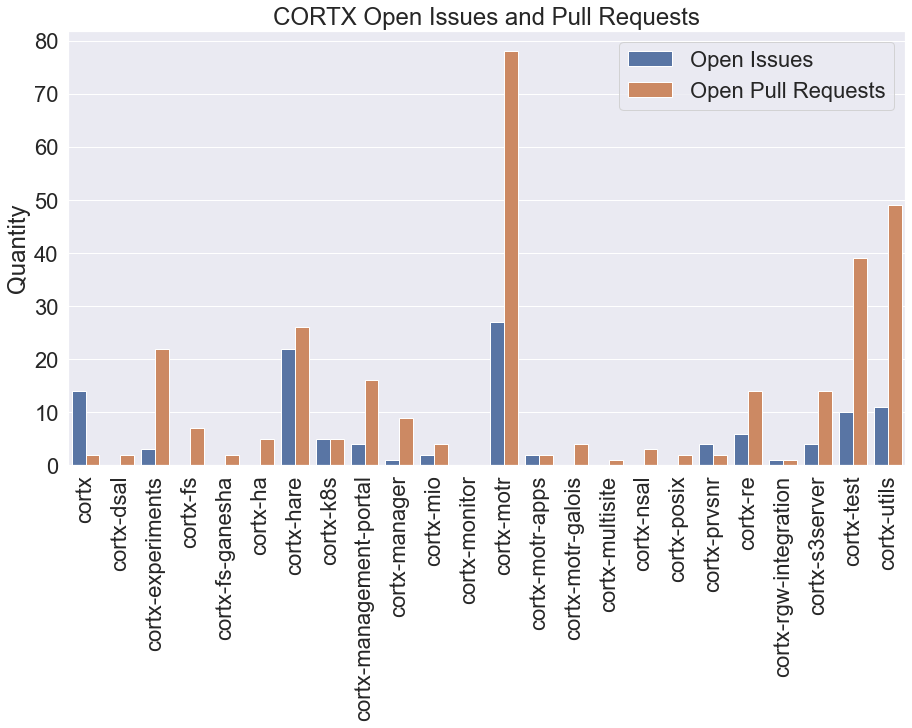

In [173]:
df = pd.DataFrame(columns=['Repo','Quantity','Type'])
for r in repos:
    repo = r.name
    num_issues = len(stats[repo]['issues_age'])
    num_prs = len(stats[repo]['pullrequests_age'])
    df.loc[len(df.index)] = [repo,num_issues,'Open Issues']
    df.loc[len(df.index)] = [repo,num_prs,'Open Pull Requests']

config={'x' : 'Repo', 'y' : 'Quantity', 'df' : df, 'hue' : 'Type', 'title' : "CORTX Open Issues and Pull Requests"}
rnames = [r.name for r in repos]
g = make_bar_graph(config,rnames)
plt.show()

In [184]:
# scrape github to get the branch count for each repo
for r in repos:
    branches = r.get_branches()
    stats[r.name]['branch_count'] = branches.totalCount
    # blech, seems to be no way to get the age of a branch...
    #stats[r.name]['branches_age'] = []
    #for b in branches:
    #    print(b.commit.commit.html_url)
    #    age = ((datetime.utcnow() - b.created_at).total_seconds()) / 86400
    #    stats[r.name]['branches_age'].append(age)
    Verbose("Repo %s has %d branches" % (r.name, stats[r.name]['branch_count']))

Repo cortx-monitor has 58 branches
Repo cortx has 19 branches
Repo cortx-s3server has 122 branches
Repo cortx-experiments has 27 branches
Repo cortx-posix has 91 branches
Repo cortx-prvsnr has 9 branches
Repo cortx-re has 35 branches
Repo cortx-ha has 17 branches
Repo cortx-hare has 30 branches
Repo cortx-management-portal has 92 branches
Repo cortx-manager has 33 branches
Repo cortx-utils has 100 branches
Repo cortx-fs has 18 branches
Repo cortx-nsal has 13 branches
Repo cortx-dsal has 15 branches
Repo cortx-fs-ganesha has 14 branches
Repo cortx-motr-galois has 19 branches
Repo cortx-motr has 272 branches
Repo cortx-test has 34 branches
Repo cortx-motr-apps has 1 branches
Repo cortx-mio has 6 branches
Repo cortx-multisite has 6 branches
Repo cortx-k8s has 21 branches
Repo cortx-rgw-integration has 36 branches


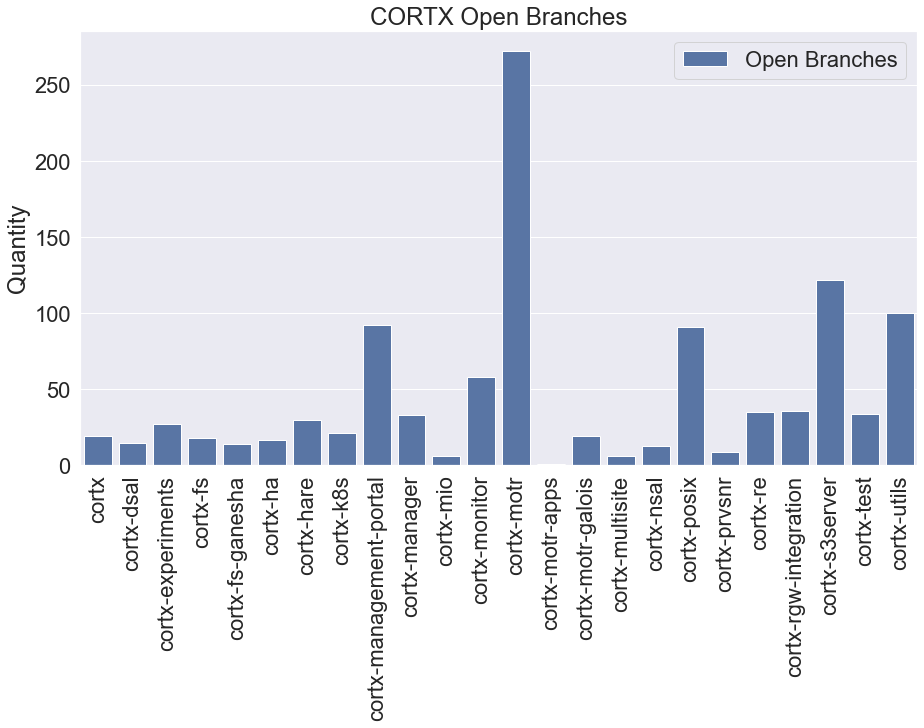

In [186]:
# make a bar graph for branch count
df = pd.DataFrame(columns=['Repo','Quantity','Type'])
for r in repos:
    repo = r.name
    num_branches = stats[r.name]['branch_count']
    df.loc[len(df.index)] = [repo,num_branches,'Open Branches']

config={'x' : 'Repo', 'y' : 'Quantity', 'df' : df, 'hue' : 'Type', 'title' : "CORTX Open Branches"}
rnames = [r.name for r in repos]
g = make_bar_graph(config,rnames)
plt.show()

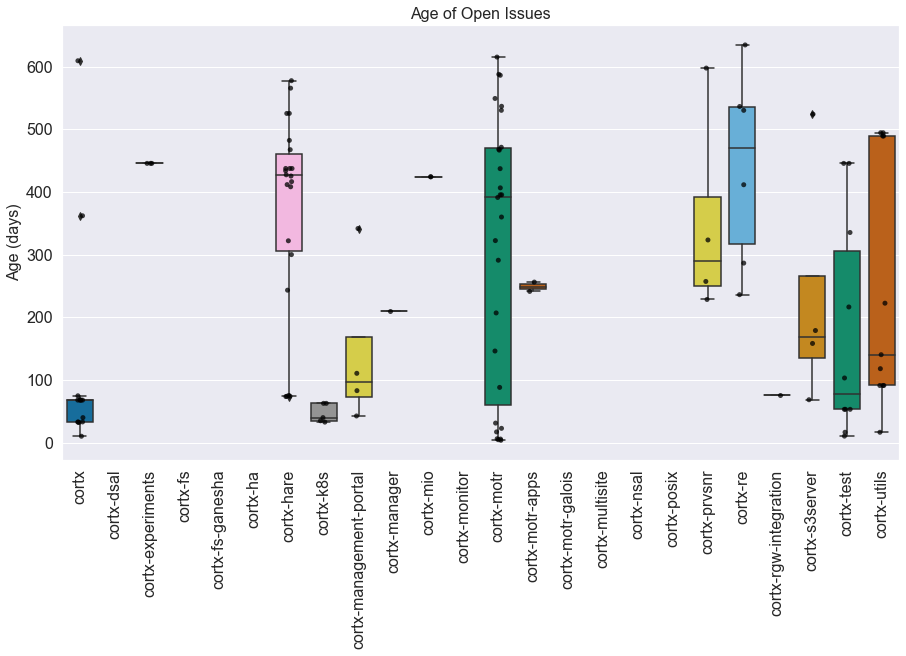

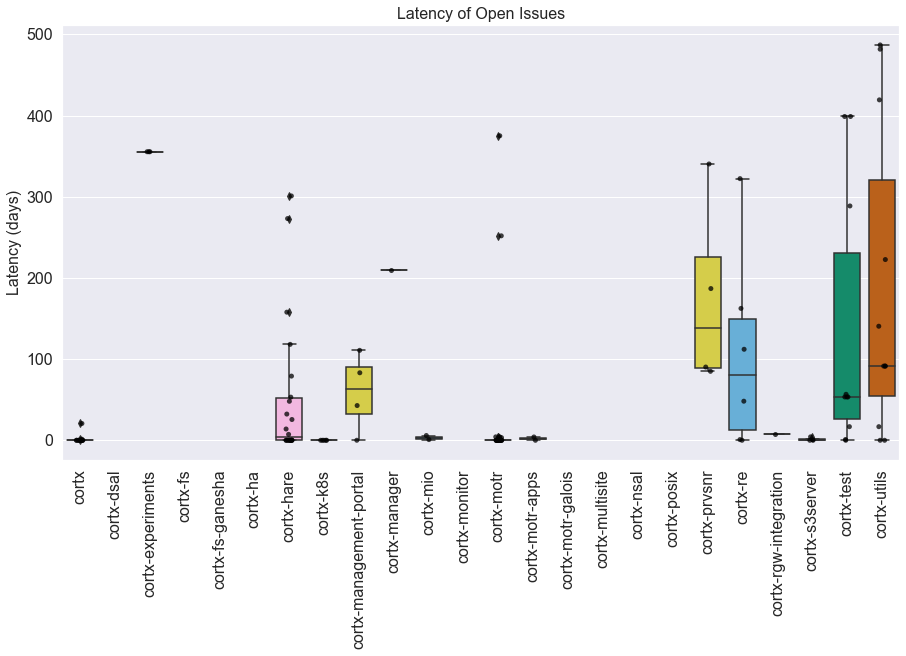

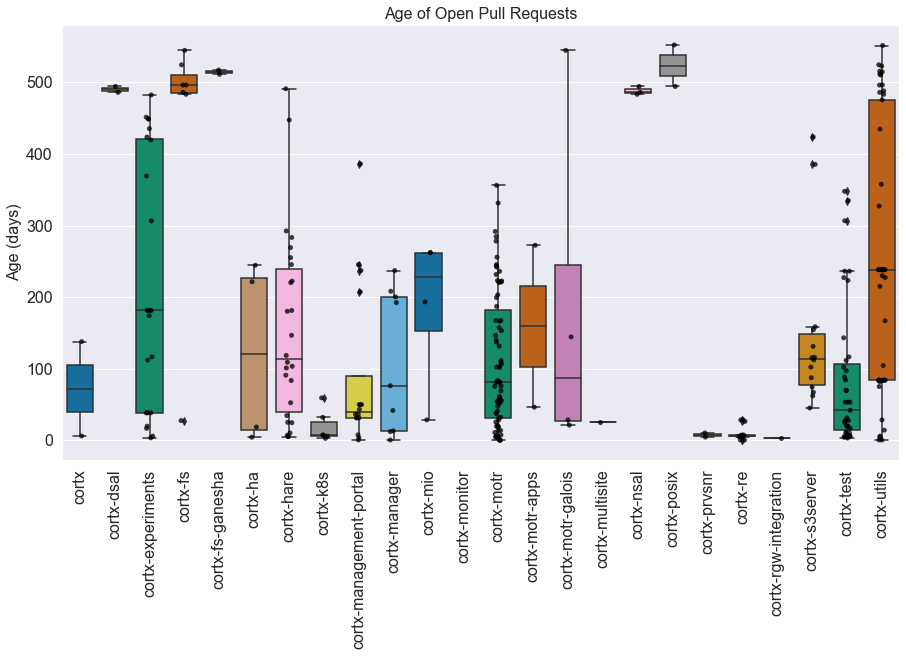

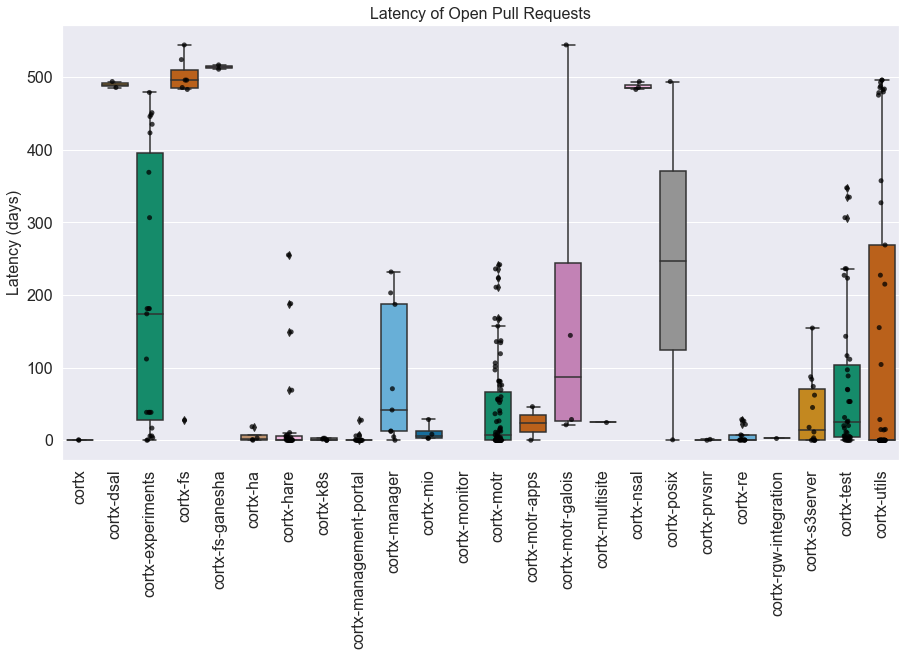

In [138]:
def make_graph(metric,title,ylabel):
    fontsize=16
    df = pd.DataFrame(
        columns=[metric,'repo'])
    sns.set(rc = {'figure.figsize':(15,8)})
    for repo in repos:
        for value in stats[repo.name][metric]:
            df.loc[len(df.index)] = [value,repo.name]
    ordering = sorted([repo.name for repo in repos])
    bplot=sns.boxplot(y=metric, x='repo', 
                 data=df, 
                 width=0.75,
                 order=ordering,
                 palette="colorblind")
    bplot=sns.stripplot(y=metric, x='repo',
              data=df, 
              order=ordering,
              color='black',
              alpha=0.75)
    
    bplot.axes.set_title(title,fontsize=16)
    bplot.set(xlabel=None)
    bplot.set_ylabel(ylabel,fontsize=fontsize)
    bplot.tick_params(labelsize=16)
    bplot.set_xticklabels(bplot.get_xticklabels(),rotation=90)
    return bplot

make_graph('issues_age','Age of Open Issues', 'Age (days)')
plt.show()
make_graph('issues_latency','Latency of Open Issues', 'Latency (days)')
plt.show()
make_graph('pullrequests_age','Age of Open Pull Requests', 'Age (days)')
plt.show()
make_graph('pullrequests_latency','Latency of Open Pull Requests', 'Latency (days)')
plt.show()

In [104]:
def get_codacy(url,data=None):
    codacy_url=url
    oath=os.getenv('CODACY_OATH')
    headers={"api-token":oath, "Accept":"application/json"}
    #print(oath)
    if data:
        headers['Content-Type'] = 'application/json'
        r = requests.post(codacy_url, headers=headers, data=data)
    else:
        r = requests.get(codacy_url, headers=headers)
    #print(r)
    #print(r.url)
    #r.text
    return r

codacy_base='https://app.codacy.com/api/v3/analysis/organizations/gh/Seagate/repositories'
response=get_codacy(codacy_base)
print(response.json())

{'data': [{'repository': {'provider': 'gh', 'owner': 'Seagate', 'name': 'cortx-k8s', 'visibility': 'Public', 'problems': [], 'languages': ['YAML', 'Shell', 'Python', 'Markdown', 'JSON'], 'repositoryId': 443042, 'remoteIdentifier': '402879730', 'lastUpdated': '2022-04-04T21:35:29Z', 'defaultBranch': {'id': 27225194, 'name': 'main', 'isDefault': True, 'isEnabled': True, 'branchType': 'Branch', 'lastUpdated': '2022-03-29T17:12:21.203Z', 'lastCommit': '77f3c930dc189a3bdaf0e98fcb2a3e6a84cf53ee'}}, 'lastAnalysedCommit': {'sha': '77f3c930dc189a3bdaf0e98fcb2a3e6a84cf53ee', 'id': 630795692, 'commitTimestamp': '2022-03-29T17:12:15Z', 'authorName': 'walterlopatka', 'authorEmail': '75284441+walterlopatka@users.noreply.github.com', 'message': 'Merge v0.2 branch into main (#190)', 'startedAnalysis': '2022-03-29T17:12:58.761Z', 'endedAnalysis': '2022-03-29T17:13:20.735Z'}, 'grade': 82, 'gradeLetter': 'B', 'issuesPercentage': 22, 'complexFilesPercentage': 0, 'duplicationPercentage': 0, 'coverage': {'f

In [72]:
Json=response.json()
if Json['pagination']['total'] >= Json['pagination']['limit']:
    print("Ugh. Have to deal with pagination.")
else:
    print("Do not need to deal with pagination")
codacy_repos = []
for item in Json['data']:
    repo=item['repository']
    rname=repo['name']
    vis=repo['visibility']
    if 'cortx' in rname and vis == 'Public':
        codacy_repos.append(rname)
print(codacy_repos)

Do not need to deal with pagination
['cortx-k8s', 'cortx-test', 'cortx-utils', 'cortx', 'cortx-motr', 'cortx-rgw', 'cortx-ha', 'cortx-re', 'cortx-hare', 'cortx-manager', 'cortx-management-portal', 'cortx-rgw-integration', 'cortx-prvsnr', 'cortx-experiments', 'cortx-nsal', 'cortx-posix', 'cortx-dsal', 'cortx-fs-ganesha', 'cortx-motr-galois', 'cortx-fs', 'cortx-mio', 'cortx-multisite', 'cortx-motr-apps', 'cortx-s3server', 'cortx-monitor']


In [87]:
def get_codacy_stats(repo):
    def set_metric(metric,metrics,Json):
        metrics[metric] = Json['data'][metric]
    url="%s/%s" % (codacy_base, 'cortx-s3server')
    response = get_codacy(url=url)
    Json = response.json()
    local_metrics = {}
    #print(Json['data']['coverage'])
    for m in ['grade', 'issuesPercentage', 'complexFilesPercentage', 'duplicationPercentage']:
        set_metric(m,local_metrics,Json)
    coverage=Json['data']['coverage']
    local_metrics['coverage'] = (1.0 * (coverage['numberTotalFiles']-coverage['filesUncovered'])) / coverage['numberTotalFiles']
    return local_metrics

metrics = {}
for r in codacy_repos:
    print("Fetching codacy %s" % r)
    metrics[r]=get_codacy_stats(r)
#print(metrics)

Fetching codacy cortx-k8s
Fetching codacy cortx-test
Fetching codacy cortx-utils
Fetching codacy cortx
Fetching codacy cortx-motr
Fetching codacy cortx-rgw
Fetching codacy cortx-ha
Fetching codacy cortx-re
Fetching codacy cortx-hare
Fetching codacy cortx-manager
Fetching codacy cortx-management-portal
Fetching codacy cortx-rgw-integration
Fetching codacy cortx-prvsnr
Fetching codacy cortx-experiments
Fetching codacy cortx-nsal
Fetching codacy cortx-posix
Fetching codacy cortx-dsal
Fetching codacy cortx-fs-ganesha
Fetching codacy cortx-motr-galois
Fetching codacy cortx-fs
Fetching codacy cortx-mio
Fetching codacy cortx-multisite
Fetching codacy cortx-motr-apps
Fetching codacy cortx-s3server
Fetching codacy cortx-monitor
{'cortx-k8s': {'grade': 83, 'issuesPercentage': 14, 'complexFilesPercentage': 0, 'duplicationPercentage': 23, 'coverage': 0.0007763975155279503}, 'cortx-test': {'grade': 83, 'issuesPercentage': 14, 'complexFilesPercentage': 0, 'duplicationPercentage': 23, 'coverage': 0.0

In [135]:
def check_security(repo):
    url=codacy_base + "/%s/issues/search" % repo
    data={}
    data['levels'] = ["Error", "Warning"]
    data["categories"] = ["Security"]
    response = get_codacy(url=url,data=json.dumps(data))
    warnings = 0
    errors = 0
    for i in response.json()['data']:
        if i['patternInfo']['level'] == 'Warning':
            warnings += 1
        elif i['patternInfo']['level'] == 'Error':
            errors += 1
        else:
            print('wtf? unknown severity level in repo %s' % repo)
    return(warnings,errors)

In [140]:
for r in codacy_repos:
    (warnings,errors) = check_security(r)
    metrics[r]['security_warnings'] = warnings
    metrics[r]['security_errors'] = errors
    print("repo %s security : %d warnings, %d errors" % (r, warnings, errors))

repo cortx-k8s security : 0 warnings, 0 errors
repo cortx-test security : 79 warnings, 21 errors
repo cortx-utils security : 48 warnings, 2 errors
repo cortx security : 93 warnings, 7 errors
repo cortx-motr security : 26 warnings, 9 errors
repo cortx-rgw security : 100 warnings, 0 errors
repo cortx-ha security : 13 warnings, 1 errors
repo cortx-re security : 6 warnings, 0 errors
repo cortx-hare security : 23 warnings, 1 errors
repo cortx-manager security : 59 warnings, 20 errors
repo cortx-management-portal security : 0 warnings, 0 errors
repo cortx-rgw-integration security : 2 warnings, 0 errors
repo cortx-prvsnr security : 6 warnings, 0 errors
repo cortx-experiments security : 17 warnings, 7 errors
repo cortx-nsal security : 0 warnings, 0 errors
repo cortx-posix security : 0 warnings, 0 errors
repo cortx-dsal security : 0 warnings, 0 errors
repo cortx-fs-ganesha security : 1 warnings, 0 errors
repo cortx-motr-galois security : 0 warnings, 0 errors
repo cortx-fs security : 10 warnings

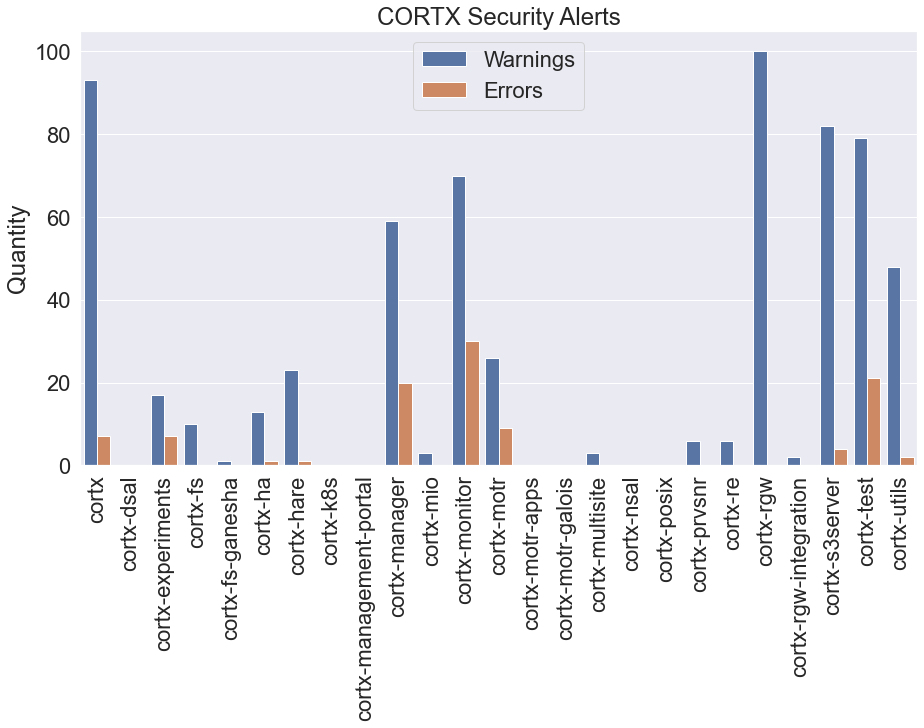

In [174]:
# make a bar chart for security
df = pd.DataFrame(columns=['Repo','Quantity','Type'])
for r in codacy_repos:
    repo = r
    sec_warn = metrics[r]['security_warnings']
    sec_err  = metrics[r]['security_errors']
    df.loc[len(df.index)] = [repo,sec_warn,'Warnings']
    df.loc[len(df.index)] = [repo,sec_err, 'Errors']

config={'x' : 'Repo', 'y' : 'Quantity', 'hue' : 'Type', 'title' : 'CORTX Security Alerts', 'df' : df}    
graph = make_bar_graph(config,codacy_repos)
plt.show()